# Pipeline for High-z Radio Galaxies 03: Radio detection classification with confirmed AGN

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and those predicted  
to be AGN by the initial Galaxy/AGN classification model (`ML_01.ipynb`).  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, brier_score_loss
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
import sklearn.pipeline
from imblearn.over_sampling import SVMSMOTE, BorderlineSMOTE, KMeansSMOTE
from betacal import BetaCalibration
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

***

## Reading data

We import our data using the `pandas` package.

In [95]:
save_plot_flag         = False
save_model_flag        = True
read_idx_flag          = True
use_AGN_gal_model_flag = False
load_model_flag        = False
use_calibration        = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [5]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Z', 'zsp', 'Sint_LOFAR', 'W1mag', 'W2mag', 'spCl', 
                      'num_imputed', 'radio_detect',] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [6]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [7]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources (in general, do not use this).

In [8]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [9]:
print(f'There are {np.sum(full_catalog_df.loc[:, "is_AGN"] == 1):,} confirmed AGN in this dataset.')

There are 50,538 confirmed AGN in this dataset.


In [10]:
if use_AGN_gal_model_flag:
    AGN_gal_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # From ML_16.ipynb

In [11]:
if use_AGN_gal_model_flag:
    new_labels_train   = pyc.predict_model(AGN_gal_clf, data=full_catalog_df,\
                                           probability_threshold=gv.AGN_thresh,\
                                           raw_score=True).loc[:, 'Score_1']

In [12]:
if use_AGN_gal_model_flag:
    full_catalog_df['class'] = new_labels_train.copy()

In [13]:
if use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_gal'] == 1, 0)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_AGN'] == 1, 1)

#### Select only confirmed and highly likely AGN

In [14]:
if use_AGN_gal_model_flag:
    AGN_threshold = 0.95
    gal_threshold = 0.05

In [15]:
if use_AGN_gal_model_flag:
    filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
    filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [16]:
if not use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [17]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

In [18]:
target_feat = 'LOFAR_detect'

## Possible correlations

In [19]:
print(full_catalog_df.columns.to_list())

['band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4', 'class']


---

Create target

In [20]:
full_catalog_df.loc[:, target_feat] = full_catalog_df.loc[:, target_feat].astype(int)

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`class == 1`)

In [21]:
filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df   = full_catalog_df.loc[filter_known_spec]
if not read_idx_flag:
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'class', use_calibration=use_calibration)
if read_idx_flag:
    known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
    train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
    train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
    validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
    calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
    test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
    train_test_df  = full_catalog_df.loc[train_validation_idx]
    train_df       = full_catalog_df.loc[train_idx]
    test_df        = full_catalog_df.loc[validation_idx]
    calibration_df = full_catalog_df.loc[calibration_idx]
    validation_df  = full_catalog_df.loc[test_idx]
    
print('Shape of used data in HETDEX')
print('-' * 60)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 60)
print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (118734, 86)
Data for Modeling (Train, Test, and Calibration): (94987, 86)
Training data:                                    (75989, 86)
Testing data:                                     (9499, 86)
Calibration data:                                 (9499, 86)
Validation data:                                  (23747, 86)
------------------------------------------------------------



In [22]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'class'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'class'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'class'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'class'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'class'] == 1)]

#### Testing of selecting balanced sub-samples for training

In [23]:
#selected_non_radio_idx_train_test = train_test_df.loc[(train_test_df.loc[:, 'LOFAR_detect'] == 0)].sample(n=np.sum(train_test_df.loc[:, 'LOFAR_detect'] == 1), 
#                                                                                                          random_state=gv.seed).index
#selected_radio_idx_train_test     = train_test_df.loc[(train_test_df.loc[:, 'LOFAR_detect'] == 1)].index

#selected_non_radio_idx_train      = train_df.loc[(train_df.loc[:, 'LOFAR_detect'] == 0)].sample(n=np.sum(train_df.loc[:, 'LOFAR_detect'] == 1), 
#                                                                                                random_state=gv.seed).index
#selected_radio_idx_train          = train_df.loc[(train_df.loc[:, 'LOFAR_detect'] == 1)].index

#selected_non_radio_idx_test       = test_df.loc[(test_df.loc[:, 'LOFAR_detect'] == 0)].sample(n=np.sum(test_df.loc[:, 'LOFAR_detect'] == 1), 
#                                                                                              random_state=gv.seed).index
#selected_radio_idx_test           = test_df.loc[(test_df.loc[:, 'LOFAR_detect'] == 1)].index

#selected_non_radio_idx_calib      = calibration_df.loc[(calibration_df.loc[:, 'LOFAR_detect'] == 0)].sample(n=np.sum(calibration_df.loc[:, 'LOFAR_detect'] == 1), 
#                                                                                                            random_state=gv.seed).index
#selected_radio_idx_calib          = calibration_df.loc[(calibration_df.loc[:, 'LOFAR_detect'] == 1)].index

In [24]:
#needed_idx_train_test             = pd.Index(selected_non_radio_idx_train_test.to_list() + selected_radio_idx_train_test.to_list())
#needed_idx_train                  = pd.Index(selected_non_radio_idx_train.to_list()      + selected_radio_idx_train.to_list())
#needed_idx_test                   = pd.Index(selected_non_radio_idx_test.to_list()       + selected_radio_idx_test.to_list())
#needed_idx_calib                  = pd.Index(selected_non_radio_idx_calib.to_list()      + selected_radio_idx_calib.to_list())

In [25]:
#train_test_df  = train_test_df.loc[needed_idx_train_test]
#train_df       = train_df.loc[needed_idx_train]
#test_df        = test_df.loc[needed_idx_test]
#calibration_df = calibration_df.loc[needed_idx_calib]

In [26]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'class'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, target_feat] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 50,538 elements,
50,538 of them are marked as AGN, and, from them, 6,419 have confirmed radio detection.


Remove intermediate targets

In [27]:
cols_to_discard_classes = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'class', 'is_str']
full_catalog_df = full_catalog_df.drop(columns=cols_to_discard_classes)
train_test_df   = train_test_df.drop(columns=cols_to_discard_classes)
train_df        = train_df.drop(columns=cols_to_discard_classes)
test_df         = test_df.drop(columns=cols_to_discard_classes)
calibration_df  = calibration_df.drop(columns=cols_to_discard_classes)
validation_df   = validation_df.drop(columns=cols_to_discard_classes)

---

In [28]:
print('Final shape of used data')
print('-' * 65)
print('(Confirmed AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 65)

Final shape of used data
-----------------------------------------------------------------
(Confirmed AGN)
--------------------------------------------------
Full confirmed dataset size:        (50538, 80)
Data for Modeling (Train and Test): (40430, 80)
Training data:                      (32344, 80)
Testing data:                       (4043, 80)
Calibration data:                   (4043, 80)
Validation data:                    (10108, 80)
-----------------------------------------------------------------


---

### Use SMOTE for over-sampling of training set.

In [29]:
SMOTE_sampler = BorderlineSMOTE(random_state=gv.seed, kind='borderline-1')

In [30]:
train_test_smote_X, train_test_smote_y = SMOTE_sampler.fit_resample(train_test_df.drop(columns=target_feat), 
                                                                    y=train_test_df.loc[:, target_feat])

In [31]:
np.shape(train_test_smote_X)

(70618, 79)

In [32]:
train_test_smote_df = pd.DataFrame(data=train_test_smote_X, 
                                   columns=train_test_df.drop(columns=target_feat).columns)
train_test_smote_df[target_feat] = train_test_smote_y

In [33]:
train_test_smote_df.columns

Index(['band_num', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag',
       'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z',
       'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i',
       'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4',
       'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4',
       'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J',
       'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1',
       'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1',
       'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4',
       'W3_W4', 'LOFAR_detect'],
      dtype='object')

In [34]:
np.shape(train_test_smote_df)

(70618, 80)

In [35]:
train_test_smote_df.describe()

,band_num,W1mproPM,W2mproPM,gmag,rmag,imag,zmag,ymag,W3mag,W4mag,Jmag,Hmag,Kmag,g_r,g_i,g_z,g_y,g_J,g_H,g_K,g_W1,g_W2,g_W3,g_W4,r_i,r_z,r_y,r_J,r_H,r_K,r_W1,r_W2,r_W3,r_W4,i_z,i_y,i_J,i_H,i_K,i_W1,i_W2,i_W3,i_W4,z_y,z_J,z_H,z_K,z_W1,z_W2,z_W3,z_W4,y_J,y_H,y_K,y_W1,y_W2,y_W3,y_W4,J_H,J_K,J_W1,J_W2,J_W3,J_W4,H_K,H_W1,H_W2,H_W3,H_W4,K_W1,K_W2,K_W3,K_W4,W1_W2,W1_W3,W1_W4,W2_W3,W2_W4,W3_W4,LOFAR_detect
count,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.00000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000,70618.000000
mean,8.686043,18.776117,18.457098,20.469831,20.184271,19.987011,19.867025,19.761133,16.457525,14.582493,17.394949,17.18395,16.558641,0.285558,0.482820,0.602805,0.708695,3.074878,3.285880,3.911187,1.693715,2.012730,4.012305,5.887336,0.197262,0.317246,0.423137,2.789320,3.000322,3.625628,1.408157,1.727172,3.726746,5.601778,0.119984,0.225875,2.592058,2.803060,3.428366,1.210895,1.529910,3.529485,5.404516,0.105890,2.472074,2.683075,3.308382,1.090910,1.409926,3.409500,5.284531,2.366184,2.577185,3.202492,0.985020,1.304036,3.303610,5.178640,0.211001,0.836308,-1.381163,-1.062148,0.937426,2.812458,0.625307,-1.592165,-1.273149,0.726425,2.601456,-2.217472,-1.898456,0.101118,1.976150,0.319015,2.318590,4.193621,1.999574,3.874605,1.875031,0.500000
std,1.435335,1.101783,1.062641,1.192130,1.159862,1.137193,1.121100,1.168333,0.477082,0.202989,0.324207,0.32634,0.228229,0.358747,0.501657,0.576458,0.701717,1.093686,1.095116,1.123166,0.913554,0.827072,0.984181,1.139423,0.299347,0.381763,0.539420,1.045171,1.045794,1.081389,0.761500,0.706682,0.934002,1.102919,0.305845,0.450405,1.010157,1.010242,1.051169,0.661969,0.635559,0.897218,1.075559,0.442309,0.999867,0.999446,1.039959,0.643582,0.634106,0.884225,1.060014,1.048600,1.047999,1.089281,0.656681,0.670840,0.939414,1.108373,0.037527,0.120502,0.962693,0.959778,0.430625,0.295815,0.120376,0.960659,0.958423,0.429723,0.296018,1.008375,0.990242,0.424878,0.225478,0.287442,0.814639,1.023250,0.757976,0.983884,0.348545,0.500004
min,2.000000,11.380000,11.719999,11.668000,11.975000,11.968000,12.019000,12.987600,10.523000,8.430000,11.979000,11.93200,11.918000,-4.513901,-4.413900,-4.363199,-4.136400,-2.280000,-2.411000,-2.621000,-2.053000,-2.773999,-3.791000,-2.952000,-4.024401,-4.057199,-3.830400,-1.759000,-1.890000,-2.100000,-1.773000,-2.462000,-3.565001,-2.431000,-6.922400,-4.628599,-1.391999,-1.519000,-1.729000,-1.561000,-2.250000,-3.353001,-2.098000,-5.188299,-1.424301,-1.214300,-1.406000,-3.280800,-2.609802,-2.105000,-1.996000,-1.780801,-1.570800,-0.920800,-3.520399,-3.377001,-1.129401,-0.481200,-0.510000,-0.720000,-2.679998,-2.359999,-2.451000,-1.348000,-0.941000,-2.889999,-2.570000,-3.013000,-1.518000,-3.539999,-3.219999,-2.674999,-1.350000,-0.964000,-3.155000,-1.697001,-2.681001,-0.833000,-0.128000,0.000000
25%,8.000000,18.162663,17.817488,19.707585,19.477303,19.344849,19.251214,19.137312,16.535124,14.620000,17.450001,17.24000,16.590000,0.098900,0.199900,0.268300,0.286200,2.328072,2.541700,3.126786,1.054326,1.485500,3.322561,5.119104,0.045033,0.117157,0.121076,2.037692,2.252006,2.888300,0.86

## Use Correlation matrix to discard some features

In [36]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_smote_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_smote_df.columns, index=train_test_smote_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [37]:
rsd_vals = (train_test_smote_df.std() / train_test_smote_df.mean() * 100).sort_values(ascending=False)

In [38]:
rsd_vals

K_W3            420.180320
z_y             417.704429
i_z             254.904366
i_y             199.404758
r_i             151.750845
r_y             127.481117
g_r             125.630282
r_z             120.336503
g_i             103.901305
LOFAR_detect    100.000708
g_y              99.015402
g_z              95.629336
W1_W2            90.103005
y_W1             66.666776
H_W3             59.155820
z_W1             58.994921
i_W1             54.667778
r_W1             54.077760
g_W1             53.937890
y_W2             51.443367
J_W3             45.936900
z_W2             44.974440
y_J              44.316093
i_W2             41.542247
g_W2             41.092022
r_W2             40.915548
y_H              40.664487
z_J              40.446501
i_J              38.971227
W2_W3            37.906849
r_J              37.470445
z_H              37.250023
i_H              36.040698
g_J              35.568445
W1_W3            35.135128
r_H              34.856057
y_K              34.013551
g

In [39]:
correlation    = norm_train_test_df.corr()

In [40]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [41]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [42]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [43]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [44]:
list_drop_corr

['g_H',
 'y_H',
 'r_H',
 'i_H',
 'z_H',
 'J_W1',
 'J_W2',
 'J_W3',
 'g_K',
 'y_K',
 'r_K',
 'i_K',
 'z_K',
 'H_W1',
 'Jmag',
 'H_W2',
 'J_W4',
 'gmag',
 'ymag',
 'rmag',
 'imag',
 'W1mproPM',
 'zmag',
 'W2mproPM',
 'K_W1',
 'K_W2',
 'Kmag',
 'g_W4',
 'y_W4',
 'r_W4',
 'i_W4',
 'z_W4',
 'H_W3',
 'W1_W4',
 'r_J',
 'i_J',
 'W2_W4',
 'J_K',
 'g_W2',
 'r_W3',
 'i_W3',
 'W1_W3',
 'H_W4',
 'r_W2',
 'W3mag',
 'g_W1',
 'r_W1',
 'g_W3',
 'y_W3',
 'z_J',
 'y_W2',
 'i_W2',
 'z_W2',
 'i_W1',
 'Hmag',
 'g_y',
 'W3_W4',
 'g_z',
 'r_y',
 'z_W3',
 'g_i',
 'g_J',
 'z_W1',
 'i_y']

In [45]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [46]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [47]:
corr_discard = norm_train_test_discard.corr()

In [48]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num        1.000000
W2_W3     y_J             0.734894
band_num  y_J             0.712355
i_z       r_z             0.640953
r_i       r_z             0.620453
W4mag     K_W3            0.608007
W2_W3     band_num        0.599610
K_W4      K_W3            0.573473
y_J       K_W3            0.533022
W2_W3     LOFAR_detect    0.466624
H_K       W1_W2           0.461704
band_num  H_K             0.446193
y_J       LOFAR_detect    0.444538
          y_W1            0.438584
W4mag     K_W4            0.436496
dtype: float64

Text(1052.0930609538775, 0.5, 'feature')

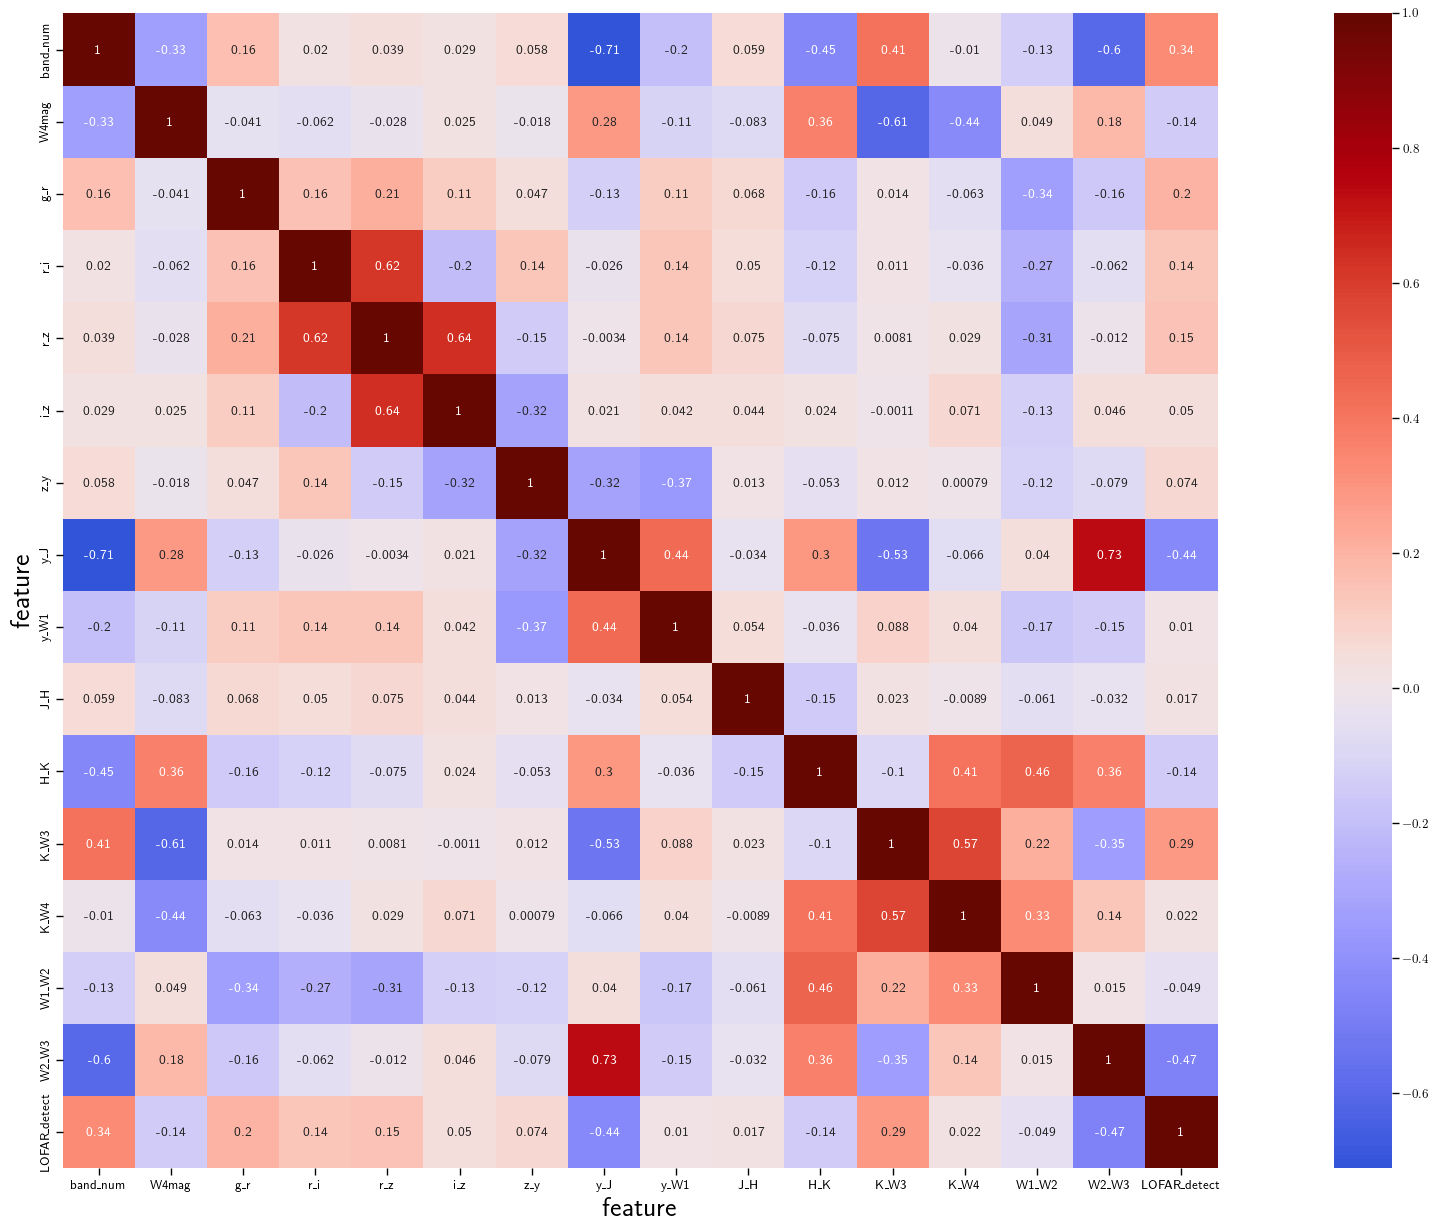

In [49]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [50]:
norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [51]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [52]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x             y           
H_K           H_K             1.000000
band_num      y_J             0.525222
K_W4          W4mag           0.451695
W1_W2         LOFAR_detect    0.403373
K_W3          LOFAR_detect    0.325117
W2_W3         LOFAR_detect    0.307560
band_num      LOFAR_detect    0.281927
              W2_W3           0.281072
y_J           LOFAR_detect    0.268168
band_num      z_y             0.259720
K_W3          K_W4            0.247449
              W2_W3           0.239720
K_W4          H_K             0.219692
y_J           W2_W3           0.190816
K_W3          y_J             0.178806
J_H           H_K             0.166846
z_y           y_J             0.161230
K_W4          K_W3            0.159638
LOFAR_detect  W2_W3           0.148435
y_J           band_num        0.143370
dtype: float64

In [53]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [54]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [55]:
list_drop_pps = []

In [56]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [57]:
list_drop_pps

[]

In [58]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [59]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [60]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,W1_W2,LOFAR_detect,0.403373,classification,True,weighted F1,0.4976,0.700254,DecisionTreeClassifier()
1,K_W3,LOFAR_detect,0.325117,classification,True,weighted F1,0.4976,0.660939,DecisionTreeClassifier()
2,W2_W3,LOFAR_detect,0.307560,classification,True,weighted F1,0.4976,0.652118,DecisionTreeClassifier()
3,band_num,LOFAR_detect,0.281927,classification,True,weighted F1,0.4976,0.639240,DecisionTreeClassifier()
4,y_J,LOFAR_detect,0.268168,classification,True,weighted F1,0.4976,0.632328,DecisionTreeClassifier()
5,z_y,LOFAR_detect,0.141542,classification,True,weighted F1,0.4976,0.568710,DecisionTreeClassifier()
6,g_r,LOFAR_detect,0.117721,classification,True,weighted F1,0.4976,0.556743,DecisionTreeClassifier()
7,y_W1,LOFAR_detect,0.101187,classification,True,weighted F1,0.4976,0.548436,DecisionTreeClassifier()
8,r_z,LOFAR_detect,0.058320,classification,True,weighted F1,0.4976,0.526900,DecisionTreeClassifier()
9,i_z,LOFAR_detect,0.042164,classification,True,weighted F1,0.4976,0.518783,DecisionTreeClassifier()


In [61]:
print(f'{len(full_catalog_df):,}')

50,538


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [62]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta

In [63]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards no features.

In [64]:
exp_radio = pyc.setup(data                     = train_test_smote_df,
                      # test_data                = test_df,
                      target                   = target_feat,
                      session_id               = gv.seed,
                      silent                   = True,
                      feature_selection        = False,
                      feature_selection_method = 'boruta',
                      data_split_stratify      = True,
                      numeric_features         = final_feats,
                      ignore_features          = feats_2_discard,
                      transformation           = True,
                      transformation_method    = 'yeo-johnson',
                      n_jobs                   = 12,
                      normalize                = True,
                      normalize_method         = 'zscore',
                      fix_imbalance            = False,
                      use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,LOFAR_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(70618, 80)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


Add F_beta score ($\beta = 1.1$).

In [65]:
pyc.add_metric('f_beta', 'F_score', gf.f_beta, greater_is_better=True)

Name                                             F_score
Display Name                                     F_score
Score Function       <function f_beta at 0x7f02302e34c0>
Scorer                               make_scorer(f_beta)
Target                                              pred
Args                                                  {}
Greater is Better                                   True
Multiclass                                          True
Custom                                              True
Name: f_beta, dtype: object

In [66]:
pyc.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'r_i', 'r_z', 'i_z', 'z_y', 'y_J', 'y_W1',
       'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W2_W3'],
      dtype='object')

In [67]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [68]:
pyc.models(internal=True).loc['gbc']['Tune Grid'].keys()

dict_keys(['n_estimators', 'learning_rate', 'subsample', 'min_samples_split', 'min_samples_leaf', 'max_depth', 'min_impurity_decrease', 'max_features'])

In [69]:
dummy_strat = DummyClassifier(strategy='stratified', random_state=gv.seed)

In [70]:
ctbst =pyc.create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.8172,0.8917,0.8495,0.7979,0.8229,0.6343,0.6356,0.8253
1,0.8184,0.8911,0.8641,0.7917,0.8263,0.6367,0.6394,0.8298
2,0.8131,0.8954,0.8535,0.7896,0.8203,0.6261,0.6282,0.8233
3,0.8238,0.8964,0.8539,0.8053,0.8289,0.6476,0.6488,0.8312
4,0.8173,0.8936,0.8592,0.7928,0.8246,0.6346,0.6369,0.8278
5,0.8159,0.8875,0.8499,0.7958,0.8219,0.6318,0.6333,0.8245
6,0.8226,0.8965,0.8612,0.7995,0.8292,0.6451,0.6471,0.8322
7,0.8230,0.8955,0.8556,0.8033,0.8286,0.6460,0.6473,0.8311
8,0.8179,0.8911,0.8507,0.7984,0.8237,0.6358,0.6372,0.8262


In [71]:
xgbst = pyc.create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.8157,0.8911,0.8487,0.7962,0.8216,0.6315,0.6328,0.8241
1,0.8261,0.8961,0.8730,0.7981,0.8338,0.6521,0.6550,0.8374
2,0.8106,0.8909,0.8523,0.7867,0.8182,0.6213,0.6235,0.8213
3,0.8268,0.8980,0.8527,0.8107,0.8312,0.6537,0.6545,0.8332
4,0.8163,0.8917,0.8535,0.7944,0.8229,0.6326,0.6344,0.8257
5,0.8181,0.8876,0.8588,0.7942,0.8252,0.6363,0.6384,0.8283
6,0.8254,0.8970,0.8621,0.8032,0.8316,0.6508,0.6526,0.8344
7,0.8195,0.8946,0.8503,0.8011,0.8250,0.6391,0.6403,0.8273
8,0.8191,0.8943,0.8487,0.8014,0.8244,0.6383,0.6394,0.8266


In [72]:
et = pyc.create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.8999,0.9634,0.9308,0.8766,0.9029,0.7998,0.8013,0.9055
1,0.9061,0.9672,0.9454,0.8766,0.9097,0.8123,0.8148,0.9130
2,0.9051,0.9712,0.9454,0.8749,0.9088,0.8102,0.8129,0.9121
3,0.9027,0.9680,0.9365,0.8772,0.9059,0.8054,0.8072,0.9087
4,0.9043,0.9674,0.9389,0.8781,0.9075,0.8086,0.8106,0.9104
5,0.8999,0.9638,0.9324,0.8754,0.9030,0.7997,0.8014,0.9057
6,0.9080,0.9705,0.9486,0.8773,0.9116,0.8159,0.8186,0.9150
7,0.9053,0.9675,0.9413,0.8781,0.9086,0.8106,0.8127,0.9116
8,0.9041,0.9681,0.9438,0.8744,0.9078,0.8082,0.8108,0.9111


In [73]:
rf = pyc.create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.8807,0.9473,0.9171,0.8548,0.8849,0.7613,0.7634,0.8878
1,0.8904,0.9530,0.9328,0.8598,0.8948,0.7807,0.7836,0.8983
2,0.8881,0.9561,0.9255,0.8611,0.8921,0.7763,0.7784,0.8952
3,0.8871,0.9541,0.9162,0.8658,0.8903,0.7742,0.7755,0.8927
4,0.8780,0.9504,0.9170,0.8506,0.8826,0.7560,0.7583,0.8857
5,0.8766,0.9487,0.9150,0.8497,0.8811,0.7532,0.7554,0.8842
6,0.8930,0.9563,0.9280,0.8673,0.8966,0.7860,0.7879,0.8995
7,0.8851,0.9524,0.9171,0.8620,0.8887,0.7702,0.7718,0.8913
8,0.8857,0.9524,0.9223,0.8594,0.8898,0.7714,0.7735,0.8928


In [74]:
gbc = pyc.create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.7759,0.8486,0.8018,0.7623,0.7815,0.5518,0.5525,0.7834
1,0.7816,0.8515,0.8127,0.7650,0.7882,0.5631,0.5642,0.7904
2,0.7706,0.8503,0.7920,0.7594,0.7754,0.5412,0.5417,0.7769
3,0.7884,0.8607,0.8029,0.7802,0.7914,0.5768,0.5770,0.7925
4,0.7744,0.8507,0.8029,0.7596,0.7806,0.5489,0.5498,0.7827
5,0.7696,0.8419,0.7932,0.7573,0.7749,0.5392,0.5398,0.7766
6,0.7898,0.8565,0.8127,0.7772,0.7945,0.5796,0.5802,0.7962
7,0.7799,0.8514,0.8002,0.7691,0.7843,0.5598,0.5602,0.7858
8,0.7744,0.8481,0.7937,0.7643,0.7787,0.5489,0.5493,0.7801


In [75]:
dummy_strt = pyc.create_model(dummy_strat)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.4931,0.4931,0.4939,0.4931,0.4935,-0.0138,-0.0138,0.4936
1,0.4996,0.4996,0.5004,0.4996,0.5000,-0.0008,-0.0008,0.5000
2,0.4930,0.4930,0.4937,0.4929,0.4933,-0.0140,-0.0140,0.4934
3,0.5072,0.5072,0.5079,0.5071,0.5075,0.0144,0.0144,0.5075
4,0.4857,0.4857,0.4864,0.4857,0.4860,-0.0285,-0.0285,0.4861
5,0.5003,0.5003,0.5010,0.5002,0.5006,0.0006,0.0006,0.5006
6,0.4991,0.4991,0.4984,0.4992,0.4988,-0.0018,-0.0018,0.4987
7,0.5043,0.5043,0.5036,0.5045,0.5040,0.0087,0.0087,0.5040
8,0.4963,0.4963,0.4956,0.4964,0.4960,-0.0075,-0.0075,0.4959


In [76]:
metric_2_sort         = 'Recall'
# final_selection_clf   = ['rf', 'catboost', 'xgboost', 'et', 'gbc', 'dummy']  # lightgbm is selected to be base learner.
final_selection_clf   = [rf, ctbst, xgbst, et, gbc, dummy_strt]
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm,dt)
n_models              = 5
top_model_radio = pyc.compare_models(n_select = n_models,
                                     include  = final_selection_clf,
                                     sort     = metric_2_sort)  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_2_sort)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score,TT (Sec)
3,Extra Trees Classifier,0.9040,0.9679,0.9409,0.8762,0.9074,0.8079,0.8102,0.9105,0.3080
0,Random Forest Classifier,0.8852,0.9527,0.9224,0.8586,0.8894,0.7705,0.7726,0.8924,0.7100
1,CatBoost Classifier,0.8191,0.8931,0.8564,0.7969,0.8256,0.6382,0.6400,0.8284,1.7830
2,Extreme Gradient Boosting,0.8198,0.8933,0.8564,0.7981,0.8262,0.6397,0.6414,0.8290,9.2790
4,Gradient Boosting Classifier,0.7783,0.8510,0.8012,0.7661,0.7832,0.5566,0.5572,0.7849,1.7220
5,Dummy Classifier,0.4972,0.4972,0.4973,0.4972,0.4972,-0.0057,-0.0057,0.4973,0.2740


Thus, we will select `Extra Trees` as meta learner.

Thus, we stack the models.

In [78]:
# base_models = top_model_radio[0:2] + top_model_radio[3:]
# meta_model  = top_model_radio[2]
base_models = top_model_radio[1:]
meta_model  = top_model_radio[0]

In [79]:
stacked_model_radio = pyc.stack_models(estimator_list = base_models,
                                       meta_model     = meta_model,
                                       optimize       = metric_2_sort,
                                       restack        = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.9013,0.9602,0.9037,0.8994,0.9015,0.8026,0.8026,0.9017
1,0.9134,0.9636,0.9171,0.9104,0.9137,0.8269,0.8269,0.9141
2,0.9120,0.9672,0.9098,0.9138,0.9118,0.8240,0.8240,0.9116
3,0.9075,0.9644,0.9025,0.9117,0.9071,0.8151,0.8151,0.9066
4,0.9071,0.9617,0.9118,0.9034,0.9076,0.8143,0.8143,0.9080
5,0.9035,0.9596,0.8984,0.9076,0.9030,0.8070,0.8070,0.9026
6,0.9088,0.9659,0.9150,0.9037,0.9093,0.8175,0.8176,0.9099
7,0.9080,0.9634,0.9053,0.9101,0.9077,0.8159,0.8159,0.9075
8,0.9045,0.9645,0.9033,0.9055,0.9044,0.8090,0.8090,0.9043


In [62]:
catboost_tune_grid          = pyc.models(internal=True).loc['catboost']['Tune Grid']
catboost_tune_grid['depth'] = [4, 5, 6, 7, 8, 9, 10, 11]  # old = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [80]:
# tuned_radio_clf = pyc.tune_model(estimator        = stacked_model_radio,
#                                  early_stopping   = True,
#                                  optimize         = metric_2_sort,
#                                  search_library   = 'tune-sklearn',
#                                  search_algorithm = 'bayesian',
#                                  choose_better    = True,
#                                  custom_grid      = catboost_tune_grid)  # 1h30
tuned_radio_clf = pyc.tune_model(estimator        = stacked_model_radio,
                                 early_stopping   = True,
                                 optimize         = metric_2_sort,
                                 search_library   = 'tune-sklearn',
                                 search_algorithm = 'bayesian',
                                 choose_better    = True)  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.8918,0.9518,0.9041,0.8824,0.8931,0.7836,0.7838,0.8941
1,0.9013,0.9572,0.9252,0.8830,0.9036,0.8026,0.8035,0.9056
2,0.8984,0.9607,0.9154,0.8853,0.9001,0.7969,0.7973,0.9016
3,0.8954,0.9578,0.9081,0.8856,0.8967,0.7908,0.7911,0.8978
4,0.8936,0.9555,0.9118,0.8797,0.8955,0.7872,0.7877,0.8970
5,0.8940,0.9529,0.9093,0.8822,0.8956,0.7880,0.7884,0.8969
6,0.9023,0.9597,0.9183,0.8898,0.9038,0.8046,0.8050,0.9052
7,0.8970,0.9566,0.9086,0.8881,0.8982,0.7941,0.7943,0.8992
8,0.8928,0.9580,0.9086,0.8808,0.8945,0.7856,0.7859,0.8958


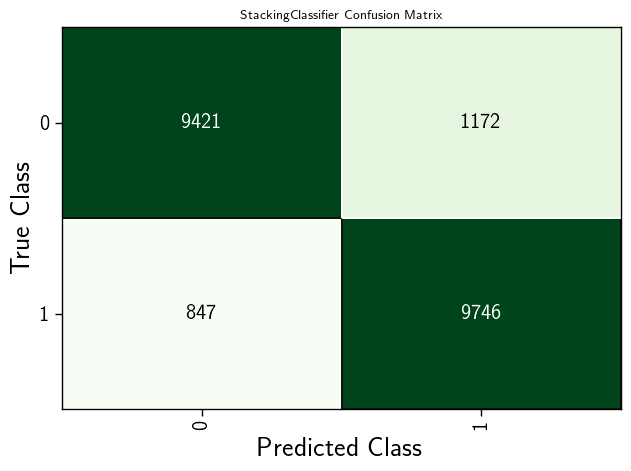

In [81]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

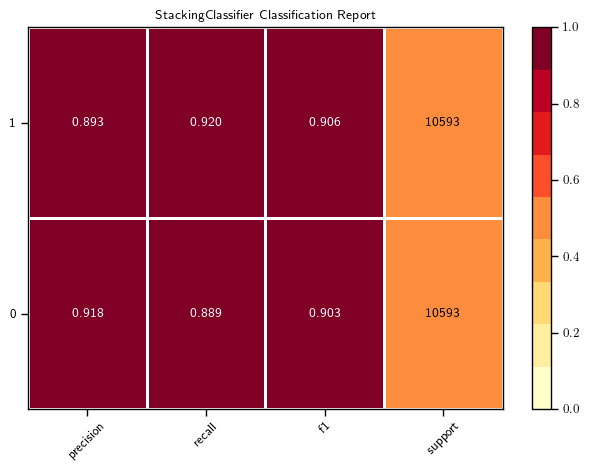

In [82]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

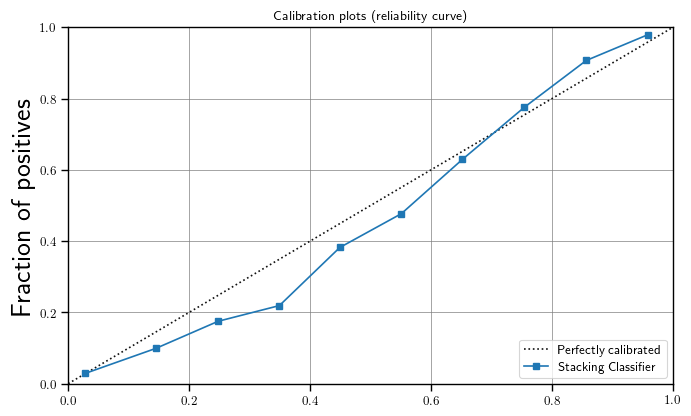

In [83]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

In [79]:
# pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [84]:
pyc.plot_model(tuned_radio_clf.final_estimator_, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,entropy
max_depth,7
max_features,0.49916016343780156
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,1.3677938075782459e-09
min_impurity_split,None


In [85]:
pyc.plot_model(tuned_radio_clf.final_estimator, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,entropy
max_depth,7
max_features,0.49916016343780156
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,1.3677938075782459e-09
min_impurity_split,None


In [86]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [87]:
pyc.predict_model(tuned_radio_clf, data=test_df, probability_threshold=gv.naive_radio_thresh,\
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9636408607,0.9805445562,0.9385796545,0.8096026490,0.8693333333,0.8483490843,0.8514762607,0.8754708767


,Score_0,Score_1
count,4043.000000,4043.000000
mean,0.802570,0.197430
std,0.291700,0.291700
min,0.025819,0.018905
25%,0.821712,0.027361
50%,0.941194,0.058806
75%,0.972639,0.178288
max,0.981095,0.974181


In [88]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9047012178,0.9624658577,0.9200415369,0.8926543323,0.9061410441,0.8094024356,0.8097836506,0.9074438214


In [89]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_c

In [90]:
pyc.predict_model(final_radio_clf, probability_threshold=gv.naive_radio_thresh,
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9927782498,0.9998770538,0.9999055980,0.9858525689,0.9928293575,0.9855564996,0.9856566456,0.9934973717


,Score_0,Score_1
count,21186.000000,21186.000000
mean,0.493537,0.506463
std,0.448903,0.448903
min,0.015573,0.021870
25%,0.037200,0.033720
50%,0.299415,0.700585
75%,0.966280,0.962800
max,0.978130,0.984427


In [96]:
if save_model_flag:
    pyc.save_model(final_radio_clf, gv.models_path + 'classification_LOFAR_detect_SMOTE_jun_03_2023')  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [97]:
if load_model_flag:
    final_radio_clf = pyc.load_model(gv.models_path + 'classification_LOFAR_detect_SMOTE_jun_03_2023')

### Prediction process

#### Feature importances

In [98]:
base_models_names = gf.get_base_estimators_names(final_radio_clf)
base_models       = gf.get_base_estimators_models(final_radio_clf)

In [99]:
print('Running data pre-processing:\n')
extended_data_radio_df = gf.preprocess_data(final_radio_clf, validation_df, base_models_names)

Running data pre-processing:



In [100]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_radio_clf, extended_data_radio_df)

In [101]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_radio_df)

In [102]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [103]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for rf...
Calculating for catboost...
Calculating for xgboost...
Calculating for gbc...


rf             catboost              xgboost                  gbc  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      W2_W3  16.366685     W2_W3  14.609087     W2_W3  27.318195     W2_W3   
1        y_J  12.474895      y_W1  11.509125      K_W3  16.028660      K_W3   
2        g_r   9.100452       z_y  10.724372       y_J   7.954187       y_J   
3       K_W3   8.806514       g_r  10.613677       r_z   6.288941       r_z   
4        z_y   8.775093     W1_W2   9.139353       g_r   5.802581       g_r   
5       y_W1   8.232336       y_J   8.789270     W4mag   5.422280       z_y   
6        r_z   8.085455       r_z   7.682615     W1_W2   4.860947     W1_W2   
7      W1_W2   7.625643      K_W3   7.030579       z_y   4.614768       r_i   
8        r_i   7.516273       r_i   7.022560       i_z   3.996338      y_W1   
9        i_z   7.174548       i_z   6.553677      y_W1   3.986533       i_z   
10  band_num   2.866088  band_num   2.282344       r_i   3.928327     W4mag   
11     W4mag   1.147130     W4mag   1.353855  band_num   3.789783  band_num   
12      K_W4   0.983249      K_W4   0.929315       J_H   2.337724       J_H   
13       H_K   0.432621       J_H   0.905870       H_K   1.848304      K_W4   
14       J_H   0.413017       H_K   0.854302      K_W4   1.822435       H_K   

               
   Importance  
0   54.059763  
1   12.720635  
2   10.339039  
3    6.666436  
4    5.777280  
5    2.231165  
6    1.939964  
7    1.659794  
8    1.592580  
9    1.406774  
10   1.323798  
11   0.137716  
12   0.066419  
13   0.040690  
14   0.037947

In [104]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance,Cumulative_sum
0,gbc,62.985111,62.985111
1,xgboost,14.949917,77.935028
2,catboost,12.154461,90.089489
3,rf,6.631944,96.721433
4,W4mag,0.981769,97.703202
5,y_J,0.622263,98.325465
6,W2_W3,0.610273,98.935737
7,band_num,0.397025,99.332762
8,K_W3,0.327227,99.659988
9,K_W4,0.119836,99.779824


In [105]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False)#.drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Cumulative_sum,Importance
Feature,,
W2_W3,41.6050,41.6050
K_W3,53.7792,12.1742
y_J,63.9983,10.2191
r_z,70.6248,6.6265
g_r,77.0443,6.4195
z_y,81.0540,4.0097
W1_W2,84.6543,3.6003
y_W1,88.2274,3.5732
r_i,91.2270,2.9995


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W2_W3	41.605
K_W3	12.174
y_J	10.219
r_z	6.627
g_r	6.420
z_y	4.010
W1_W2	3.600
y_W1	3.573
r_i	3.000
W4mag	2.867
i_z	2.768
band_num	1.518
K_W4	0.596
J_H	0.540
H_K	0.484


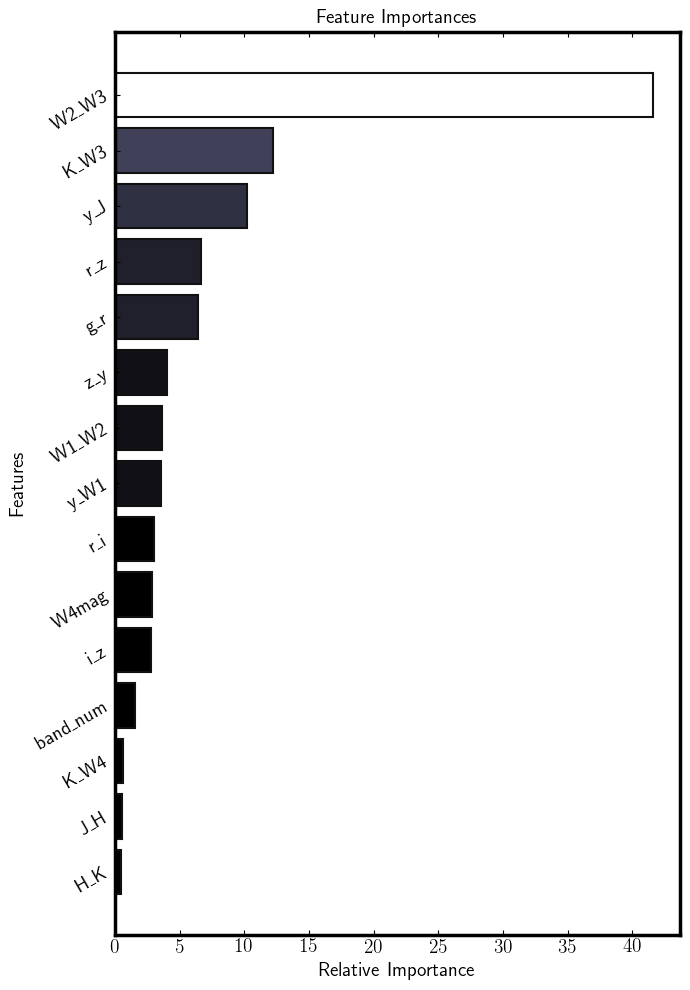

In [106]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_radio_detect_05.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [107]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_radio_clf, 'gbc', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,gbc,rf,catboost,xgboost,gbc
n_estimators,290,100.0000,NaN,100.0000,100.0000
min_samples_split,4,2.0000,NaN,NaN,2.0000
min_samples_leaf,2,1.0000,NaN,NaN,1.0000
max_depth,7,NaN,NaN,6.0000,3.0000
min_impurity_decrease,0.0000,0.0000,NaN,NaN,0.0000
max_features,0.4992,auto,NaN,NaN,None
bootstrap,NaN,True,NaN,NaN,NaN
criterion,NaN,gini,NaN,NaN,NaN
class_weight,NaN,NaN,NaN,NaN,NaN
learning_rate,NaN,NaN,0.0634,0.3000,0.1000


---

In [108]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 32,344
Size of test set is  4,043


#### Calculate optimal threshold for classification

In [109]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9869218402,0.9984005263,0.9985333659,0.9073745002,0.9507738857,0.9432529932,0.9446900655,0.9551147819


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9886223102,0.9999046302,1.0000000000,0.9188712522,0.9577205882,0.9511608547,0.9522972721,0.9615837336


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9871877319,0.9986989194,0.9988283538,0.9090101297,0.9518049870,0.9444356870,0.9458299242,0.9560820460


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9878802869,0.9998637985,1.0000000000,0.9121863799,0.9540768510,0.9471127548,0.9484401059,0.9582585096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8451721409,0.7905856211,0.4036979969,0.3984790875,0.4010715653,0.3121705867,0.3121793006,0.4013196528


#### Naive threshold metrics.

In [110]:
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [111]:
naive_scores_df = gf.create_scores_df([cm_mat_train_naive, cm_mat_test_naive, cm_mat_train_test_naive, cm_mat_calib_naive, cm_mat_val_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [112]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9551,0.9447,0.9074,0.9985
Test,0.9616,0.9523,0.9189,1.0000
Train+Test,0.9561,0.9458,0.9090,0.9988
Calibration,0.9583,0.9484,0.9122,1.0000
Validation,0.4013,0.3122,0.3985,0.4037


#### Calibration curve

In [113]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib, mean_pred_val_calib =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

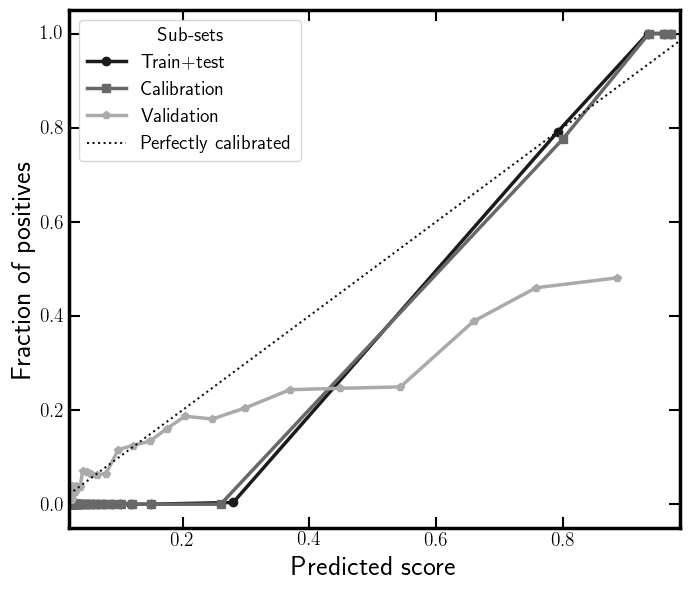

In [114]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

min_x = np.nanmin([np.nanmin(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(validation_prediction_clf.loc[:, 'Score_1'])])
max_x = np.nanmax([np.nanmax(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(validation_prediction_clf.loc[:, 'Score_1'])])

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib, fract_positiv_calib, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=min_x * 0.99999, right=max_x * 1.00001)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_pre_calib_radio.pdf', bbox_inches='tight')
plt.show()

#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [115]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_calib      = roc_auc_score(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [116]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for calibraton = {roc_auc_calib:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99840
Area under the curve (ROC) for test       = 0.99990
Area under the curve (ROC) for train+test = 0.99870
Area under the curve (ROC) for calibraton = 0.99986
Area under the curve (ROC) for validation = 0.79059


In [117]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_calib,      tpr_calib,      thresh_calib      = roc_curve(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

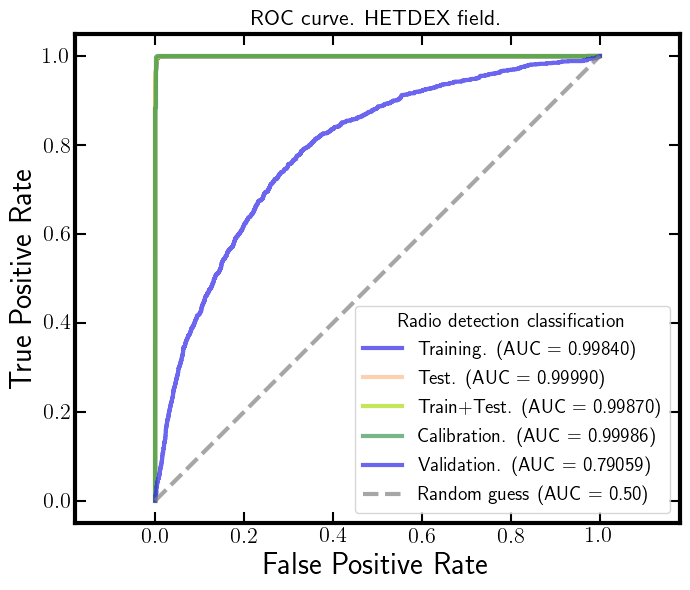

In [118]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_calib       = RocCurveDisplay(fpr=fpr_calib,      tpr=tpr_calib,      roc_auc=roc_auc_calib)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, label=f"Training.    (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, label=f"Test.        (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, label=f"Train+Test.  (AUC = {roc_auc_train_test:0.5f})")
viz_calib.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, label=f"Calibration. (AUC = {roc_auc_calib:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.7, label=f"Validation.  (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=22)
ax1.set_ylabel('True Positive Rate', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

##### Obtain optimal thresholds from each sub-set

In [119]:
opt_thres_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_thres_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_thres_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_thres_calib      = thresh_calib[np.argmax(tpr_calib - fpr_calib)]
opt_thres_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [120]:
print(f'Optimal threshold from area under the curve (ROC) for training    = {opt_thres_train:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for test        = {opt_thres_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for train+test  = {opt_thres_train_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for calibration = {opt_thres_calib:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for validation  = {opt_thres_validation:.8e}')

Optimal threshold from area under the curve (ROC) for training    = 6.52974292e-01
Optimal threshold from area under the curve (ROC) for test        = 6.48988689e-01
Optimal threshold from area under the curve (ROC) for train+test  = 6.52974292e-01
Optimal threshold from area under the curve (ROC) for calibration = 6.78669668e-01
Optimal threshold from area under the curve (ROC) for validation  = 1.17991428e-01


##### Precision-Recall curve

In [121]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_calib,      recall_calib,      thresh_calib      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [122]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_calib      = auc(recall_calib,      prec_calib)
auc_pr_validation = auc(recall_validation, prec_validation)

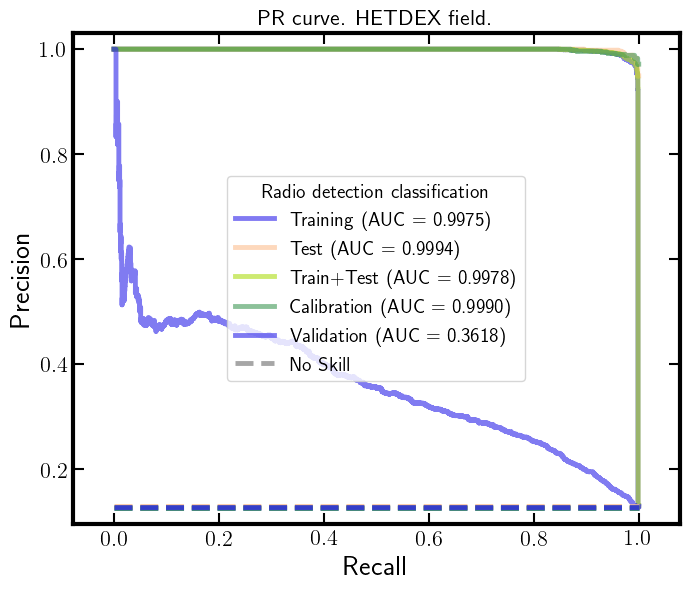

In [123]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib,      recall=recall_calib)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test        (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc='best', fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [124]:
fscore_train      = (1 + gv.beta_F**2) * (prec_train      * recall_train)      / (prec_train * gv.beta_F**2      + recall_train)
fscore_test       = (1 + gv.beta_F**2) * (prec_test       * recall_test)       / (prec_test * gv.beta_F**2       + recall_test)
fscore_train_test = (1 + gv.beta_F**2) * (prec_train_test * recall_train_test) / (prec_train_test * gv.beta_F**2 + recall_train_test)
fscore_calib      = (1 + gv.beta_F**2) * (prec_calib      * recall_calib)      / (prec_calib * gv.beta_F**2      + recall_calib)
fscore_validation = (1 + gv.beta_F**2) * (prec_validation * recall_validation) / (prec_validation * gv.beta_F**2 + recall_validation)

In [125]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_calib      = thresh_calib[np.argmax(fscore_calib)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [126]:
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train:.8e}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib:.8e}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation:.8e}')

Optimal threshold from Precision-Recall curve for training    = 6.70174402e-01
Optimal threshold from Precision-Recall curve for test        = 6.72703539e-01
Optimal threshold from Precision-Recall curve for train+test  = 6.70174402e-01
Optimal threshold from Precision-Recall curve for calibration = 7.13040797e-01
Optimal threshold from Precision-Recall curve for validation  = 2.69408936e-01


In [127]:
print(f'The selected threshold, from train+test sub-set is {opt_t_PR_train_test:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_train_test}')

The selected threshold, from train+test sub-set is 0.67017
And, in its complete extension, is 0.6701744017


---

In [128]:
radio_pred_threshold = float(opt_t_PR_train_test) # 4.97101925e-01

In [129]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=radio_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9953314371,0.9984005263,0.9926668296,0.9710664754,0.9817478545,0.9790716327,0.9791495145,0.9827750921


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9970319070,0.9999046302,0.9961612284,0.9810964083,0.9885714286,0.9868660279,0.9869038602,0.9892876148


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9955973287,0.9986989194,0.9937512205,0.9721107927,0.9828118965,0.9802875679,0.9803656993,0.9838410020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9962898837,0.9998637985,1.0000000000,0.9713740458,0.9854791868,0.9833529464,0.9834892302,0.9868409038


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8640680649,0.7905856211,0.2850539291,0.4534313725,0.3500473037,0.2785241914,0.2878976623,0.3426241875


Create confusion matrices.

In [130]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [131]:
radio_scores_array_df = gf.create_scores_df([cm_mat_train, cm_mat_test, cm_mat_train_test, cm_mat_calib, cm_mat_val],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [132]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_array_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9828,0.9791,0.9711,0.9927
Test,0.9893,0.9869,0.9811,0.9962
Train+Test,0.9838,0.9804,0.9721,0.9938
Calibration,0.9868,0.9835,0.9714,1.0000
Validation,0.3426,0.2879,0.4534,0.2851


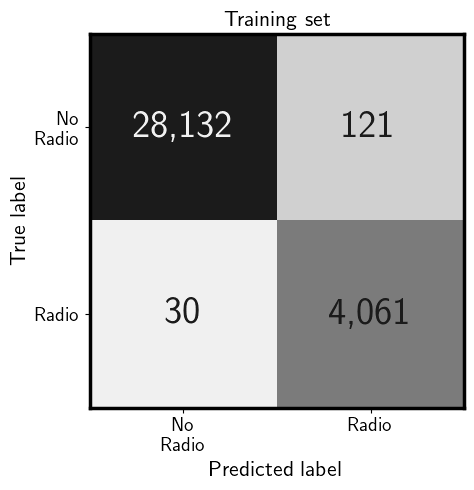

In [133]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

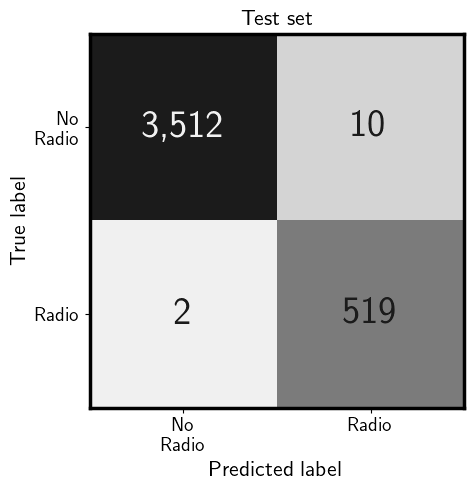

In [134]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

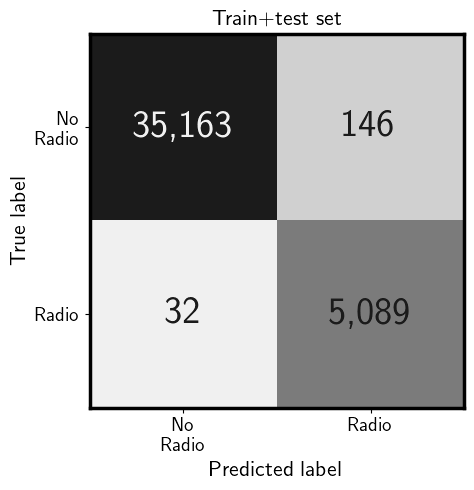

In [135]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

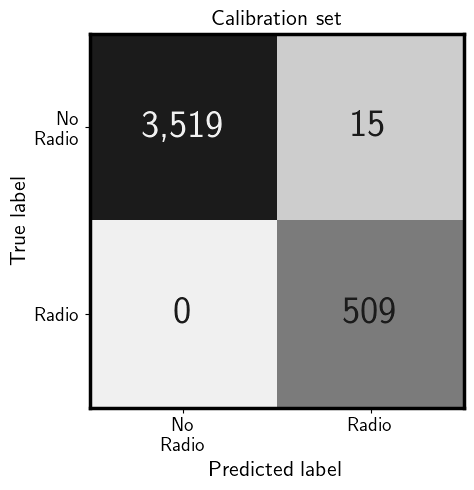

In [136]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

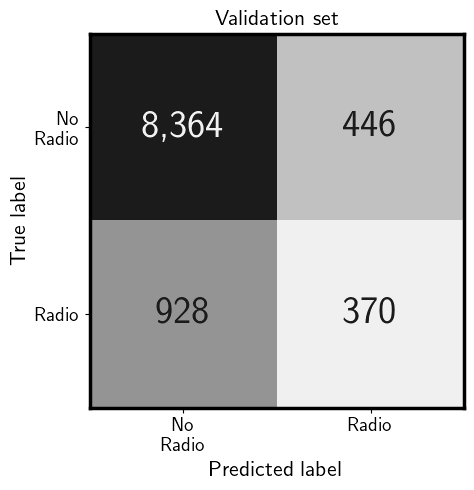

In [137]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [138]:
print('Running data pre-processing for calibration (train+test):\n')
extended_calibration_df = gf.preprocess_data(final_radio_clf, calibration_df, base_models_names)
initial_cols            = extended_calibration_df.columns.drop(base_models_names)

Running data pre-processing for calibration (train+test):



In [139]:
if not save_model_flag:
    calibrated_final_radio_clf = BetaCalibration(parameters='abm')
    calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])

In [140]:
calibrated_final_radio_clf = BetaCalibration(parameters='abm')
calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
if save_model_flag:
    calibrated_final_radio_clf = BetaCalibration(parameters='abm')
    calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
    dump(calibrated_final_radio_clf, gv.models_path + 'cal_classification_LOFAR_detect_SMOTE_jun_03_2023.joblib')

In [141]:
# if load_model_flag:
#     calibrated_final_radio_clf = load(gv.models_path + gv.cal_radio_model)

In [142]:
train_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(train_prediction_clf.loc[:, 'Score_1'])
test_prediction_clf['Prob_radio']       = calibrated_final_radio_clf.predict(test_prediction_clf.loc[:, 'Score_1'])
train_test_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(train_test_prediction_clf.loc[:, 'Score_1'])
calib_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(calib_prediction_clf.loc[:, 'Score_1'])
validation_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(validation_prediction_clf.loc[:, 'Score_1'])

In [143]:
train_prediction_clf['Label_cal_naive']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
test_prediction_clf['Label_cal_naive']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= gv.naive_radio_thresh).astype(int)
train_test_prediction_clf['Label_cal_naive'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)
calib_prediction_clf['Label_cal_naive']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
validation_prediction_clf['Label_cal_naive'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)

In [144]:
cm_mat_val_cal_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal_naive'])
cm_mat_train_cal_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal_naive'])
cm_mat_test_cal_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal_naive'])
cm_mat_calib_cal_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal_naive'])
cm_mat_train_test_cal_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal_naive'])

In [145]:
radio_scores_cal_naive_df = gf.create_scores_df([cm_mat_train_cal_naive, cm_mat_test_cal_naive,\
                                              cm_mat_train_test_cal_naive, cm_mat_calib_cal_naive, cm_mat_val_cal_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [146]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_naive_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9781,0.9752,0.9804,0.9763
Test,0.9832,0.9812,0.9884,0.9789
Train+Test,0.9796,0.9768,0.9814,0.9781
Calibration,0.9878,0.9855,0.9825,0.9921
Validation,0.2951,0.2616,0.4696,0.2257


### Obtain uncertainty values from calibrated model and naive threshold

In [172]:
subsets_arr = [train_prediction_clf, test_prediction_clf, 
               train_test_prediction_clf, calib_prediction_clf, 
               validation_prediction_clf]

In [173]:
subset_names = ['train', 'test', 'train + test', 'calibration', 'validation']

In [174]:
CV_object_cal_naive = StratifiedKFold(n_splits=10, random_state=gv.seed, shuffle=True)

In [175]:
cv_scores_cal_naive = {}

In [176]:
for count, (subset, subset_name) in enumerate(zip(subsets_arr, subset_names)):
    tmp_f_betas = []
    tmp_mccs    = []
    tmp_precs   = []
    tmp_recalls = []
    for _, fold_index in iter(CV_object_cal_naive.split(subset.loc[:, 'Score_1'], subset.loc[:, target_feat])):
        tmp_f_beta = pyc.get_metrics().loc['f_beta', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label_cal_naive'])
        tmp_mcc    = pyc.get_metrics().loc['mcc', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                    subset.iloc[fold_index].loc[:, 'Label_cal_naive'])
        tmp_prec   = pyc.get_metrics().loc['precision', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                          subset.iloc[fold_index].loc[:, 'Label_cal_naive'])
        tmp_recall = pyc.get_metrics().loc['recall', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label_cal_naive'])
        tmp_f_betas.append(tmp_f_beta)
        tmp_mccs.append(tmp_mcc)
        tmp_precs.append(tmp_prec)
        tmp_recalls.append(tmp_recall)
    cv_scores_cal_naive[subset_name] = {'f_beta': tmp_f_betas, 'mcc': tmp_mccs, 'precision': tmp_precs, 'recall': tmp_recalls}

In [177]:
cv_scores_mean_cal_naive = {}
cv_scores_std_cal_naive  = {}

In [178]:
for sub_set in cv_scores_cal_naive:
    cv_scores_mean_cal_naive[sub_set] = {}
    cv_scores_std_cal_naive[sub_set] = {}
    for score in cv_scores_cal_naive[sub_set]:
        cv_scores_mean_cal_naive[sub_set][score] = np.nanmean(cv_scores_cal_naive[sub_set][score])
        cv_scores_std_cal_naive[sub_set][score]  = np.nanstd(cv_scores_cal_naive[sub_set][score])

In [179]:
for sub_set in cv_scores_cal_naive:
    print('-' * 20 + sub_set + '-' * 20)
    print(f'F_beta score for {sub_set} set: {cv_scores_mean_cal_naive[sub_set]["f_beta"]:.4f} ± {cv_scores_std_cal_naive[sub_set]["f_beta"]:.4f}')
    print(f'MCC for {sub_set} set:          {cv_scores_mean_cal_naive[sub_set]["mcc"]:.4f} ± {cv_scores_std_cal_naive[sub_set]["mcc"]:.4f}')
    print(f'Precision for {sub_set} set:    {cv_scores_mean_cal_naive[sub_set]["precision"]:.4f} ± {cv_scores_std_cal_naive[sub_set]["precision"]:.4f}')
    print(f'Recall score for {sub_set} set: {cv_scores_mean_cal_naive[sub_set]["recall"]:.4f} ± {cv_scores_std_cal_naive[sub_set]["recall"]:.4f}')
    print('-' * 55)

--------------------train--------------------
F_beta score for train set: 0.9781 ± 0.0050
MCC for train set:          0.9752 ± 0.0059
Precision for train set:    0.9804 ± 0.0085
Recall score for train set: 0.9763 ± 0.0059
-------------------------------------------------------
--------------------test--------------------
F_beta score for test set: 0.9831 ± 0.0132
MCC for test set:          0.9812 ± 0.0149
Precision for test set:    0.9884 ± 0.0128
Recall score for test set: 0.9789 ± 0.0159
-------------------------------------------------------
--------------------train + test--------------------
F_beta score for train + test set: 0.9796 ± 0.0034
MCC for train + test set:          0.9768 ± 0.0038
Precision for train + test set:    0.9814 ± 0.0049
Recall score for train + test set: 0.9781 ± 0.0060
-------------------------------------------------------
--------------------calibration--------------------
F_beta score for calibration set: 0.9877 ± 0.0079
MCC for calibration set:          

#### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [147]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Prob_radio'],       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)
prec_calib_cal,      recall_calib_cal,      thresh_calib_cal      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)

AUC for PR curve

In [148]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_calib_cal      = auc(recall_calib_cal,      prec_calib_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

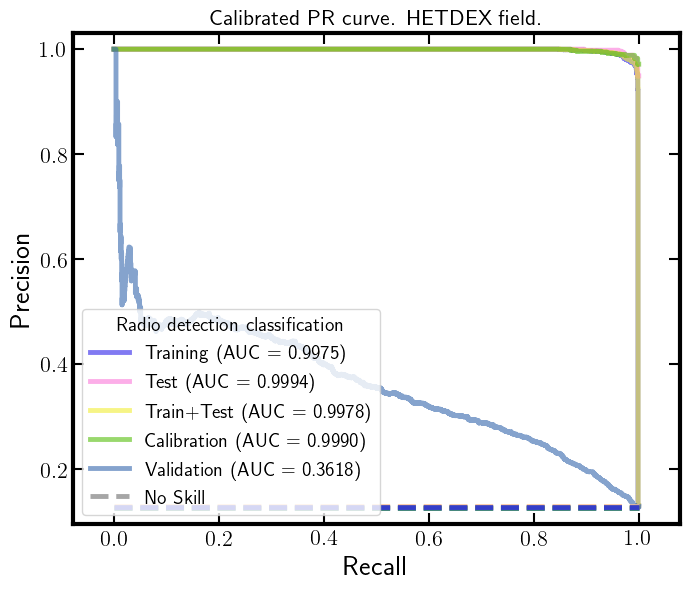

In [149]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib_cal,      recall=recall_calib_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.3), alpha=0.6, label=f"Test        (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.5), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test_cal:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.7), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.9), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [150]:
fscore_train_cal      = (1 + gv.beta_F**2) * (prec_train_cal      * recall_train_cal)      / (prec_train_cal * gv.beta_F**2      + recall_train_cal)
fscore_test_cal       = (1 + gv.beta_F**2) * (prec_test_cal       * recall_test_cal)       / (prec_test_cal * gv.beta_F**2       + recall_test_cal)
fscore_train_test_cal = (1 + gv.beta_F**2) * (prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal * gv.beta_F**2 + recall_train_test_cal)
fscore_calib_cal      = (1 + gv.beta_F**2) * (prec_calib_cal      * recall_calib_cal)      / (prec_calib_cal * gv.beta_F**2      + recall_calib_cal)
fscore_validation_cal = (1 + gv.beta_F**2) * (prec_validation_cal * recall_validation_cal) / (prec_validation_cal * gv.beta_F**2 + recall_validation_cal)

In [151]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_calib_cal      = thresh_calib_cal[np.argmax(fscore_calib_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [152]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training    = 0.18274
Optimal threshold from Precision-Recall curve for test        = 0.19495
Optimal threshold from Precision-Recall curve for train+test  = 0.18274
Optimal threshold from Precision-Recall curve for calibration = 0.45631
Optimal threshold from Precision-Recall curve for validation  = 0.00000


In [153]:
print(f'The selected threshold, from calibration sub-set is {opt_t_PR_calib_cal:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_calib_cal}')

The selected threshold, from calibration sub-set is 0.45631
And, in its complete extension, is 0.4563060507739932


In [154]:
train_prediction_clf['Label_cal']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
test_prediction_clf['Label_cal']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= opt_t_PR_calib_cal).astype(int)
train_test_prediction_clf['Label_cal'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)
calib_prediction_clf['Label_cal']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
validation_prediction_clf['Label_cal'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)

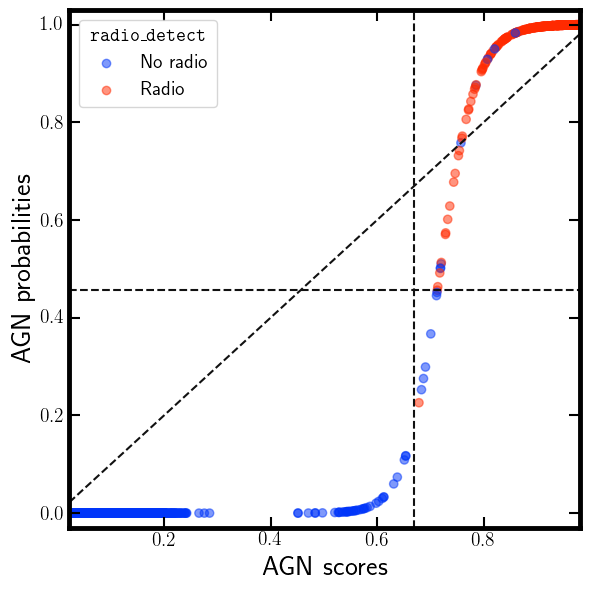

In [155]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

set_to_plot     = calib_prediction_clf

ax1.scatter(set_to_plot.loc[:, 'Score_1'], set_to_plot.loc[:, 'Prob_radio'], marker='o',\
            alpha=0.5, c=set_to_plot.loc[:, target_feat],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat]))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=opt_t_PR_calib_cal, color='k', ls='dashed')
ax1.axvline(x=opt_t_PR_train_test, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_detect}$', title_fontsize=14)
ax1.set_xlim(left=set_to_plot.loc[:, 'Score_1'].min() * 0.99999, right=set_to_plot.loc[:, 'Score_1'].max() * 1.00001)
ax1.set_ylim(bottom=-0.03, top=1.03)
fig.tight_layout()
plt.show()

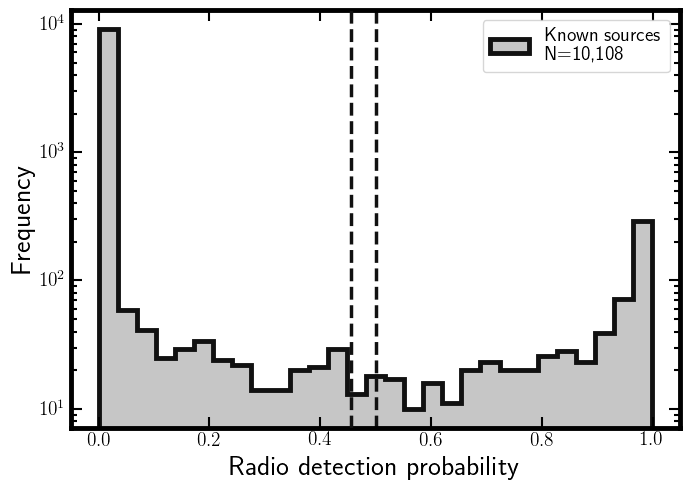

In [156]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

set_to_plot     = validation_prediction_clf

min_score  = np.nanmin(set_to_plot.loc[:, 'Prob_radio'])
max_score  = np.nanmax(set_to_plot.loc[:, 'Prob_radio'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(set_to_plot.loc[:, 'Prob_radio'])

ax1.hist(set_to_plot.loc[:, 'Prob_radio'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_calib_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_radio_cal_scores_pred_AGN_known.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [157]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib_cal, mean_pred_val_calib_cal =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

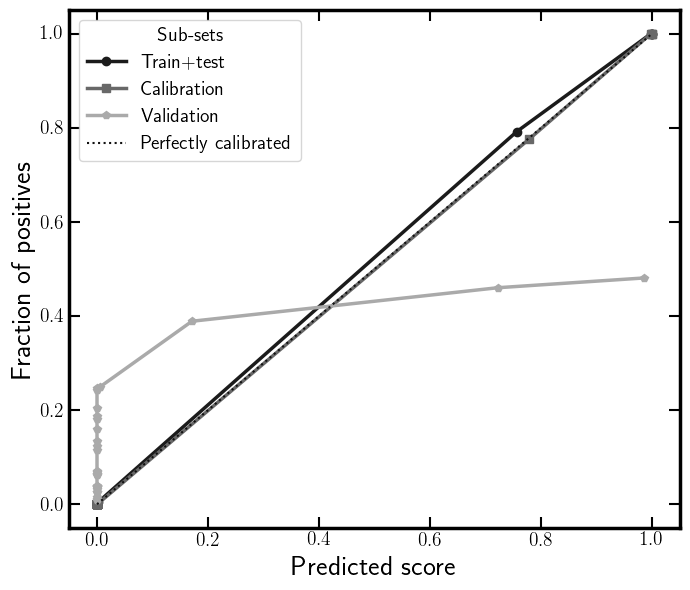

In [158]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib_cal, fract_positiv_calib_cal, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val_cal, fract_positiv_val_cal, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_post_calib_radio.pdf', bbox_inches='tight')
plt.show()

### Check if calibration was useful

Brier score is used for this. And, in particular, Brier Skill Score (BSS).  
Its values can be in the range $[0, 1]$

If BSS $\ll 0$, calibration was not succesful. If BSS $\approx 0$, it performs as the previous model.  
If BSS $\gg 0$, calibration is useful and performs better than original model.

In [159]:
BS_ref = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label'],     pos_label=1)
BS     = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label_cal'], pos_label=1)
BSS    = 1 - (BS/BS_ref)

In [160]:
print(f'Brier Skill Score is {BSS:.3f} using the validation set.')

Brier Skill Score is 0.025 using the validation set.


Create confusion matrices.

In [161]:
cm_mat_val_cal        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal'])
cm_mat_train_cal      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal'])
cm_mat_test_cal       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal'])
cm_mat_calib_cal      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal'])
cm_mat_train_test_cal = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal'])

In [162]:
radio_scores_cal_df = gf.create_scores_df([cm_mat_train_cal, cm_mat_test_cal,\
                                              cm_mat_train_test_cal, cm_mat_calib_cal, cm_mat_val_cal],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [163]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9789,0.9759,0.9794,0.9785
Test,0.9864,0.9846,0.9884,0.9846
Train+Test,0.9809,0.9781,0.9807,0.9811
Calibration,0.9910,0.9889,0.9826,0.9980
Validation,0.2997,0.2638,0.4673,0.2311


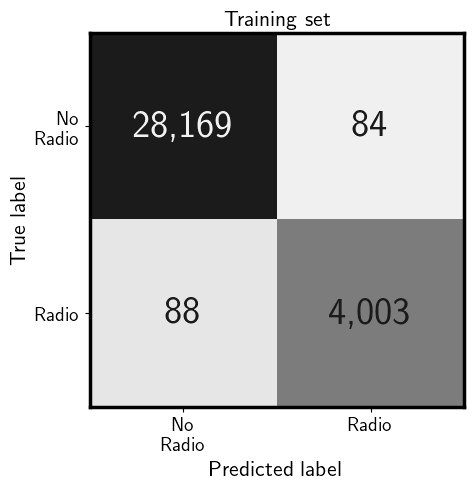

In [164]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_cal, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

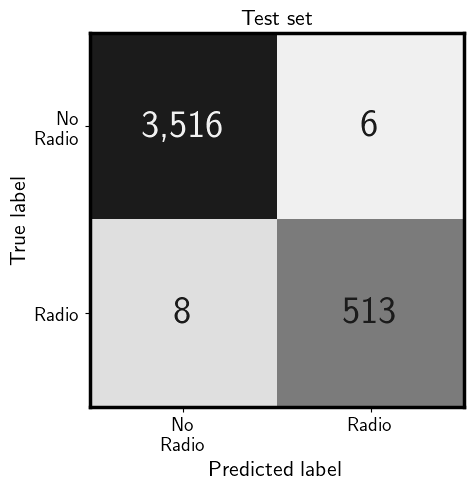

In [165]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test_cal, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

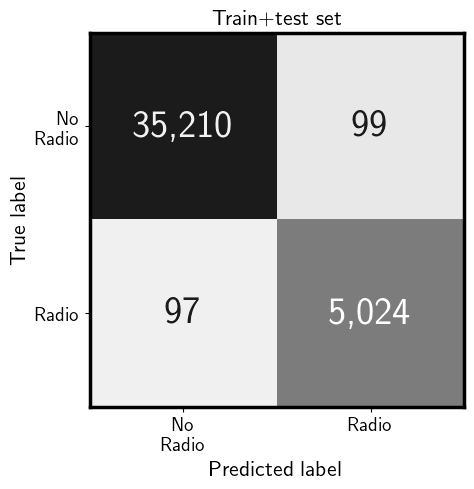

In [166]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_mat_train_test_cal, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

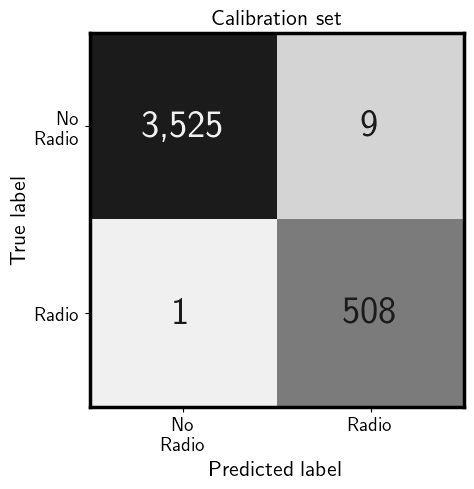

In [167]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib_cal, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

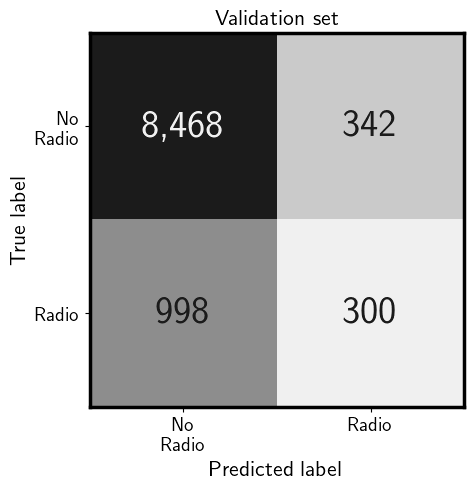

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [168]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val_cal, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

### Obtain uncertainty values from calibrated model and threshold

In [180]:
CV_object_cal = StratifiedKFold(n_splits=10, random_state=gv.seed, shuffle=True)

In [181]:
cv_scores_cal = {}

In [182]:
for count, (subset, subset_name) in enumerate(zip(subsets_arr, subset_names)):
    tmp_f_betas = []
    tmp_mccs    = []
    tmp_precs   = []
    tmp_recalls = []
    for _, fold_index in iter(CV_object_cal.split(subset.loc[:, 'Score_1'], subset.loc[:, target_feat])):
        tmp_f_beta = pyc.get_metrics().loc['f_beta', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label_cal'])
        tmp_mcc    = pyc.get_metrics().loc['mcc', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                    subset.iloc[fold_index].loc[:, 'Label_cal'])
        tmp_prec   = pyc.get_metrics().loc['precision', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                          subset.iloc[fold_index].loc[:, 'Label_cal'])
        tmp_recall = pyc.get_metrics().loc['recall', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label_cal'])
        tmp_f_betas.append(tmp_f_beta)
        tmp_mccs.append(tmp_mcc)
        tmp_precs.append(tmp_prec)
        tmp_recalls.append(tmp_recall)
    cv_scores_cal[subset_name] = {'f_beta': tmp_f_betas, 'mcc': tmp_mccs, 'precision': tmp_precs, 'recall': tmp_recalls}

In [183]:
cv_scores_mean_cal = {}
cv_scores_std_cal  = {}

In [184]:
for sub_set in cv_scores_cal:
    cv_scores_mean_cal[sub_set] = {}
    cv_scores_std_cal[sub_set] = {}
    for score in cv_scores_cal[sub_set]:
        cv_scores_mean_cal[sub_set][score] = np.nanmean(cv_scores_cal[sub_set][score])
        cv_scores_std_cal[sub_set][score]  = np.nanstd(cv_scores_cal[sub_set][score])

In [185]:
for sub_set in cv_scores_cal:
    print('-' * 20 + sub_set + '-' * 20)
    print(f'F_beta score for {sub_set} set: {cv_scores_mean_cal[sub_set]["f_beta"]:.4f} ± {cv_scores_std_cal[sub_set]["f_beta"]:.4f}')
    print(f'MCC for {sub_set} set:          {cv_scores_mean_cal[sub_set]["mcc"]:.4f} ± {cv_scores_std_cal[sub_set]["mcc"]:.4f}')
    print(f'Precision for {sub_set} set:    {cv_scores_mean_cal[sub_set]["precision"]:.4f} ± {cv_scores_std_cal[sub_set]["precision"]:.4f}')
    print(f'Recall score for {sub_set} set: {cv_scores_mean_cal[sub_set]["recall"]:.4f} ± {cv_scores_std_cal[sub_set]["recall"]:.4f}')
    print('-' * 55)

--------------------train--------------------
F_beta score for train set: 0.9789 ± 0.0048
MCC for train set:          0.9759 ± 0.0057
Precision for train set:    0.9795 ± 0.0080
Recall score for train set: 0.9785 ± 0.0060
-------------------------------------------------------
--------------------test--------------------
F_beta score for test set: 0.9863 ± 0.0146
MCC for test set:          0.9845 ± 0.0166
Precision for test set:    0.9884 ± 0.0128
Recall score for test set: 0.9846 ± 0.0168
-------------------------------------------------------
--------------------train + test--------------------
F_beta score for train + test set: 0.9809 ± 0.0027
MCC for train + test set:          0.9781 ± 0.0029
Precision for train + test set:    0.9807 ± 0.0044
Recall score for train + test set: 0.9811 ± 0.0057
-------------------------------------------------------
--------------------calibration--------------------
F_beta score for calibration set: 0.9910 ± 0.0059
MCC for calibration set:          